# Bright Star Hold 2017:068 analysis

The BSH entry occurred at <code>2017:068:17:00:42</code> following the maneauver to ObsID 50255.

### __Content__

* Study telemetry from two observations prior to the NSM transition:
    
    * ObsID = 50256
    
    * ObsID = 50255


* Gyro bias estimate in ObsID=50256.


* Star acquisition during ObsID=50255, and the full field search at the start of the BSH transition.


* Offset from the planned attitude:

    * Offset = 148.6 arcsec
    * Offset decomposition: Roll = 127.4 arcsec, Pitch = -42.8 arcsec, Yaw = 142.3 arcsec

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
import astropy.units as u
import Ska.engarchive.fetch as fetch
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from chandra_aca.plot import plot_stars
from Quaternion import Quat
import agasc
import Ska.engarchive.fetch as fetch
from mica.archive import aca_l0, asp_l1
import Ska.arc5gl
import os
from kadi import events
from itertools import cycle

In [11]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(obc_sol['time'], drs, '-b', label='Roll')
    plot_cxctime(obc_sol['time'], dps, '-g', label='Pitch')
    plot_cxctime(obc_sol['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.xlabel('Time')
    #plt.legend(loc='best');


def get_att_offset(quat, q_planned):
    offset = agasc.agasc.sphere_dist(quat.ra, quat.dec,
                                     q_planned.ra, q_planned.dec)
    offset = (offset * u.deg).to('arcsec').value
    print('Offset = {:.1f} arcsec'.format(offset))

    dq = quat.dq(q_planned)

    print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
    print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
    print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))

    return (dq.roll0 * 3600, dq.pitch * 3600, dq.yaw * 3600, offset)


def get_av_telem_from_stars(msids, times, ffs=False):
    """
    Compute average telemetry values, return astropy Table.
    
    Note: assumes that telemetry, telem, and full field search
    index, ok, are defined beforehand.
    """
    rows = []
    row = {}
    times_av = (telem['aoacmag0'].times > times[0]) & (telem['aoacmag0'].times < times[1])
    
    for idx, msid in enumerate(msids):
        average = telem[msid].vals[times_av].mean()
        row[msid[:-1]] = average
        if ffs:
            row[msid[:-1] + '_ffs'] = telem[msid].vals[ok]
        if np.mod(idx, 3) == 2:
            row['slot'] = idx // 3
            rows.append(row)
            row = {}
            
    t = Table(rows)
    cols = t.colnames
    cols.remove('slot')
    for col in cols:
        t[col].format = '%.3f'

    return t


def plot_telem(msids, times, obs_times, ffs=None):
    """
    Note: assumes that telemetry, telem, and full field search
    time, time_ffs, are defined beforehand.
    """

    plt.figure(figsize=(7.5, 26))
    
    for idx, msid in enumerate(msids):
        plt.subplot(8, 3, idx + 1, axisbg='lightgray')
        plot_cxctime(telem[msid].times, telem[msid].vals)
        plt.ylabel(msid)
        plt.xlabel("Time")
        text = '_ffs' if ffs else ''
        label = t[msid[:-1] + text][idx // 3]
        plt.title('{} = {:.3f}'.format(msid[4:7], label))
        plt.margins(0.05)  

    # Mark obsid time span (white) and reference times (dashed lines)
    for idx, ax in enumerate(plt.gcf().axes):
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
        ax.axvspan(obs_times[0], obs_times[1], ymin=-5000, ymax=5000, color='white')
        cc = 'r' if ffs is not None else 'k'
        ax.vlines(DateTime(times).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
                  color=cc, linestyle='--')
        if ffs is not None:
            for idx, time in enumerate(ffs['time']):
                ax.vlines(DateTime(time).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
                          color=ffs['color'][idx], linestyle='dashed')

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

    return

In [4]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']
slots = range(8)
msids_star = []
for slot in slots:
    msids = [key + np.str(slot) for key in keys]
    msids_star = msids_star + msids

### Maneuvers and ObsIDs prior to BSH ###

In [5]:
# https://icxc.cfa.harvard.edu/mp/mplogs/2017/MAR0617/oflsa/starcheck.html#obsid50260

obsids = [50256, 50255]

manvrs = events.manvrs.filter(start='2017:068:16:00:00.000',
                              stop='2017:068:18:00:00.000')

rows = []
for i, manvr in enumerate(manvrs):
    row = {'manvr': i + 1, 'start': manvr.start, 'stop': manvr.stop,
           'one_shot': manvr.one_shot, 'dur': manvr.dur,
           'tstart': manvr.tstart, 'tstop': manvr.tstop,
           'angle': manvr.angle, 'to_obsid': obsids[i]}
    rows.append(row)

tab = Table(rows,
            names=('manvr', 'start', 'stop', 'one_shot',
                   'tstart', 'tstop', 'dur', 'angle', 'to_obsid'),
            dtype=('i2', 'S20', 'S20', 'f4',
                   'f8', 'f8', 'f4', 'f4', 'i4'))

for col in tab.colnames[3:-1]:
    tab[col].format = '%.2f'
    
print(tab['manvr', 'start', 'stop', 'dur', 'one_shot', 'angle', 'to_obsid'])

manvr        start                 stop           dur   one_shot angle  to_obsid
----- -------------------- -------------------- ------- -------- ------ --------
    1 2017:068:15:18:14.14 2017:068:16:06:13.36 2879.23    50.37 166.41    50256
    2 2017:068:16:27:23.34 2017:068:16:59:35.46 1932.13   -99.00  95.42    50255


## OBSID=50256 ##

### Offset from the planned attitude, using ground and on-board attitude solutions ###

In [54]:
# Starcheck, OBSID=50256
# MP_TARGQUAT at 2017:068:15:18:08.440 (VCDU count = 7516924)
# Q1,Q2,Q3,Q4: -0.19892659  -0.31782754  0.91150559  0.16903083

q_planned = Quat([-0.19892659, -0.31782754, 0.91150559, 0.16903083])

In [45]:
asol_file = 'pcadf605462972_asol1.fits'
grnd_sol = Table.read(asol_file)

In [46]:
obc_file = 'pcadf605462972_osol1.fits'
obc_sol = Table.read(obc_file)
obc_sol = obc_sol[:-1]

In [47]:
# Check if the times match
grnd_sol2 = grnd_sol[3:][::4]
np.max(obc_sol['time'] - grnd_sol2['time'])

0.0

In [ ]:
"""
print('Ground att. estimate, start of ObsID = 50260:\n')
q_ref = Quat(grnd_sol2['q_att'][0])
result = get_att_offset(q_ref, q_planned)

print('\nGround att. estimate, end of ObsID = 50260:\n')
q_ref = Quat(grnd_sol2['q_att'][-1])
result = get_att_offset(q_ref, q_planned)

print('OBC att. estimate, start of ObsID = 50260:\n')
q_ref = Quat(obc_sol['q_att'][0])
result = get_att_offset(q_ref, q_planned)

print('\nOBC att. estimate, end of ObsID = 50260:\n')
q_ref = Quat(obc_sol['q_att'][-1])
result = get_att_offset(q_ref, q_planned)
"""

### Gyro bias analysis ###

In [15]:
msids = ['aogbias1', 'aogbias2', 'aogbias3']
axes = ['Roll', 'Pitch', 'Yaw']
colors = 'bgm'

In [16]:
start = obc_sol['time'][0] # Time of the one shot update
stop = obc_sol['time'][-1]
telem = fetch.MSIDset(msids, start=start, stop=stop)


ObsID=50256 (before manvr. prior to BSH)


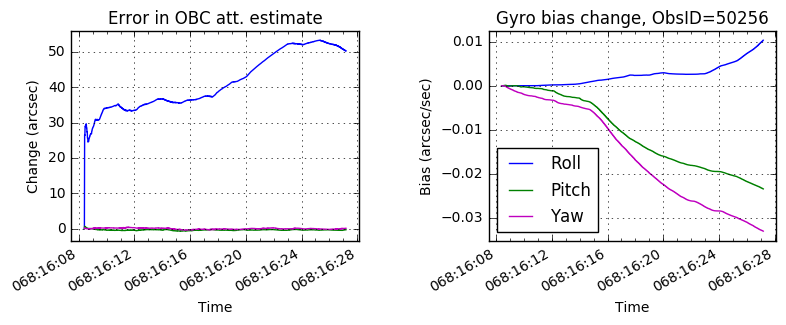

In [17]:
%matplotlib inline

print('\nObsID=50256 (before manvr. prior to BSH)')

plt.figure(figsize=(7.5, 3))

plt.subplot(1, 2, 1)

label = 'Error in OBC att. estimate'
plot_att_changes(refs=grnd_sol2, atts=obc_sol, label=label)

plt.subplot(1, 2, 2)

colors = 'bgm'
for i, msid in enumerate(msids):
    plot_cxctime(telem[msid].times,
                 ((telem[msid].vals - telem[msid].vals[0]) * u.radian / u.s).to('arcsec/s'),
                 color=colors[i], label=axes[i])

plt.ylabel('Bias (arcsec/sec)')
plt.xlabel('Time')
plt.title('Gyro bias change, ObsID=50256')
plt.margins(0.05)
plt.legend(loc='best')
plt.grid();

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45)


ObsID=50256 (before manvr. prior to BSH)


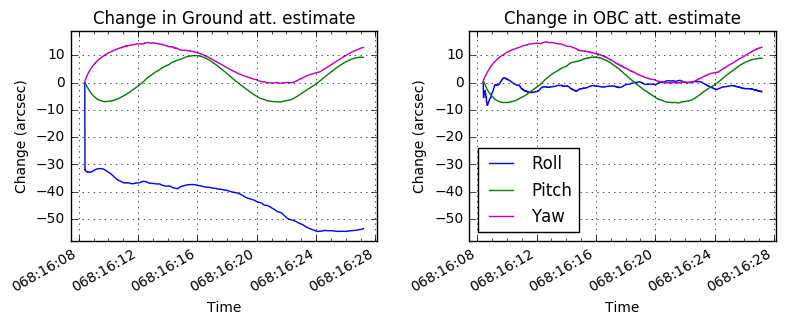

In [18]:
print('\nObsID=50256 (before manvr. prior to BSH)')

plt.figure(figsize=(7.5, 3))

plt.subplot(1, 2, 1)

label = 'Change in Ground att. estimate'
plot_att_changes(refs=grnd_sol2[:1], atts=grnd_sol2, label=label)
plt.ylim(-58, 19)

plt.subplot(1, 2, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=grnd_sol2[:1], atts=obc_sol, label=label)
plt.ylim(-58, 19)
plt.legend(loc='best')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3)

### Offset from the planned attitude, using star telemetry ###

In [19]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstart'][0]
stop = tab['tstop'][1]
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

# Define reference times for average mag, yan, zan calculations
start_av = tab['tstop'][0] + 180
stop_av = tab['tstart'][1] - 5
times = [start_av, stop_av]

t = get_av_telem_from_stars(msids_star, times)

White: ObsID 50256
Gray: Maneuvers


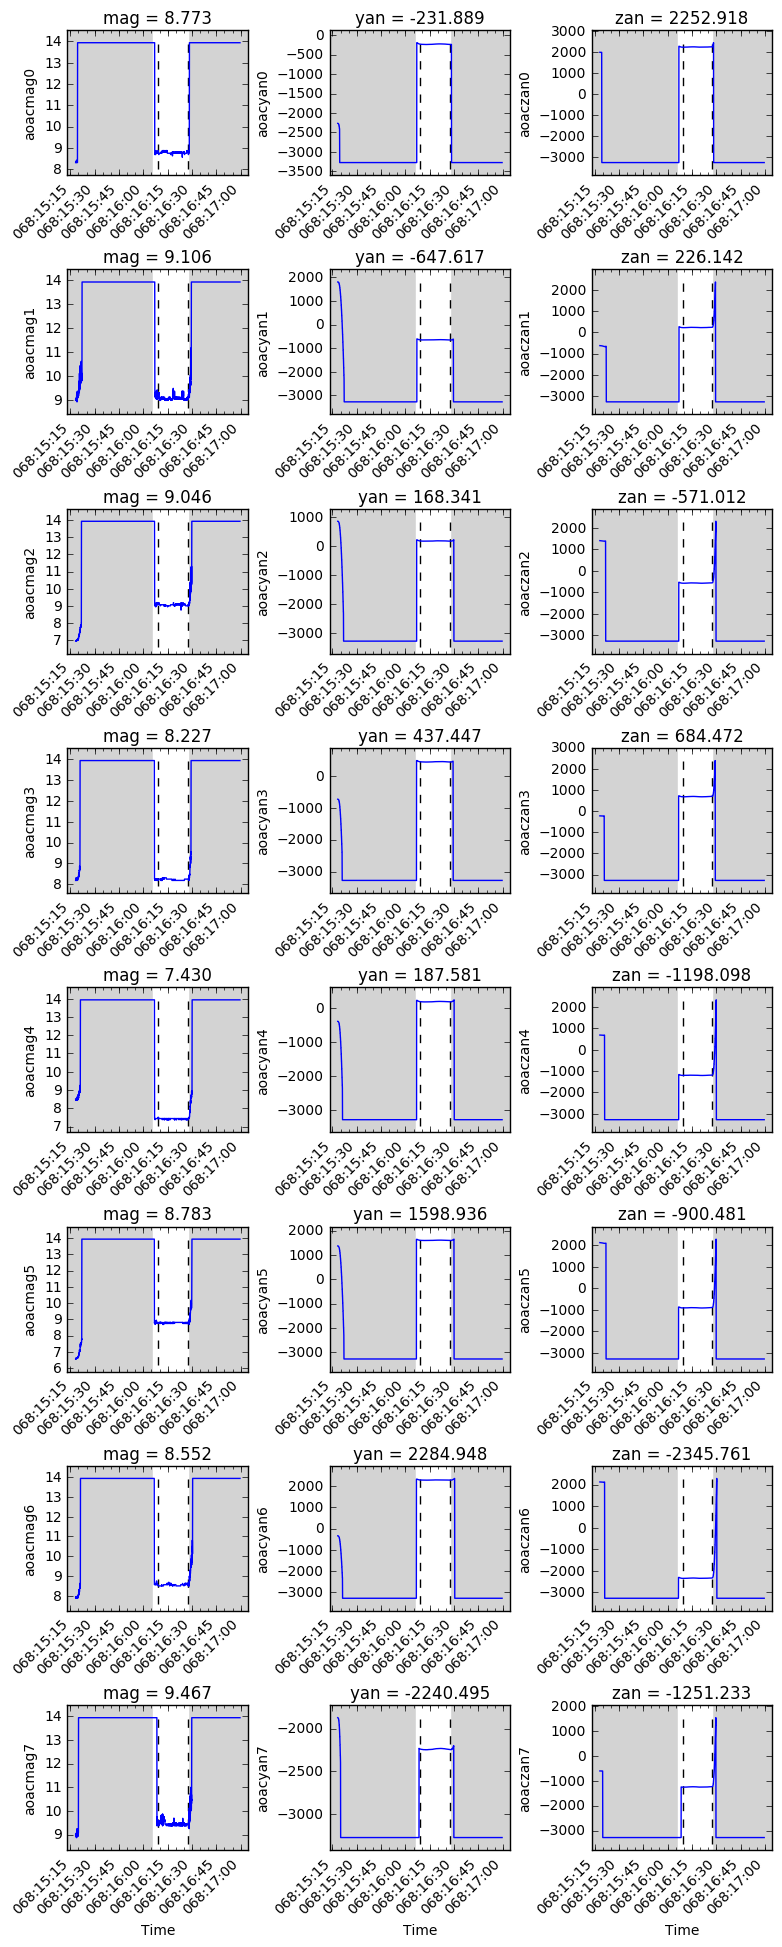

In [22]:
start_50256 = DateTime(tab['tstop'][0]).plotdate
stop_50256 = DateTime(tab['tstart'][1]).plotdate
obs_times = [start_50256, stop_50256]

print('White: ObsID 50256')
print('Gray: Maneuvers')

plot_telem(msids_star, times, obs_times)

In [23]:
print(t['slot', 'aoacyan', 'aoaczan', 'aoacmag'])

slot  aoacyan   aoaczan  aoacmag
---- --------- --------- -------
   0  -231.889  2252.918   8.773
   1  -647.617   226.142   9.106
   2   168.341  -571.012   9.046
   3   437.447   684.472   8.227
   4   187.581 -1198.098   7.430
   5  1598.936  -900.481   8.783
   6  2284.948 -2345.761   8.552
   7 -2240.495 -1251.233   9.467


All stars match their respective commanded catalog entries. Star acquired in slot 7 is the GUI (dim=1) not the ACQ (dim=20) star. 

In [55]:
# Kadi, attitude solution:

# Attitude solution
# Coordinates
#
# RA=153.29005786
# Dec=-14.7859242657
# Roll=318.021675418
# 
# Q1=-0.198935734276
# Q2=-0.317858483705
# Q3=0.911494640823
# Q4=0.169020938689
#
#  
# Star match summary and residuals 
#
# slot      YAG            ZAG       MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- -------------- -------------- ------- -------- ----- -------- ----- ---- ----------
#   0 -231.888634216  2252.91795841 8.77333  -231.93  0.04  2253.20 -0.28 0.29  720378144
#   1 -647.616706049  226.142178639 9.10574  -647.44 -0.17   226.19 -0.04 0.18  720379064
#   2  168.341280718 -571.012121928 9.04643   168.48 -0.14  -571.25  0.23 0.27  720379688
#   3   437.44676276  684.471904537 8.22672   437.47 -0.02   684.48 -0.01 0.02  720379744
#   4  187.580529301 -1198.09832231 7.43023   187.58  0.00 -1198.13  0.03 0.03  794169304
#   5  1598.93558601 -900.480789225 8.78344  1599.17 -0.23  -900.73  0.25 0.34  794175152
#   6  2284.94834594 -2345.76148393 8.55246  2284.89  0.06 -2345.46 -0.30 0.30  794177720
#   7 -2240.49539225 -1251.23298677 9.46745 -2240.97  0.47 -1251.35  0.12 0.49  719457696

q_kadi = Quat([-0.198935734276, -0.317858483705, 0.911494640823, 0.169020938689])

results = get_att_offset(q_kadi, q_planned)

Offset = 1.8 arcsec
d(Roll) = 14.5 arcsec
d(Pitch) = -0.9 arcsec
d(Yaw) = -1.6 arcsec


In [58]:
### ????

q_obc_sol = obc_sol['q_att'][-1]
dq = Quat(q_obc_sol).dq(q_obc)

q_grnd_sol = grnd_sol2['q_att'][-1]
q_grnd = Quat(q_grnd_sol) * dq

print('\nOffset between Ground and kadi estimated attitudes just before the maneuver before BSH:\n')
result = get_att_offset(q_kadi, q_grnd)


Offset between Ground and kadi estimated attitudes just before the maneuver before BSH:

Offset = 7.9 arcsec
d(Roll) = -35.5 arcsec
d(Pitch) = -0.7 arcsec
d(Yaw) = -7.9 arcsec


## OBSID=50255 ##

### Star acquisition during ObsID=50255, and during BSH full field search###

In [50]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstop'][1]
stop = '2017:068:17:05:00'
time_bsh = '2017:068:17:00:42'
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

# Define reference times for average mag, yan, zan calculations
start_av = DateTime('2017:068:17:00:25').secs
stop_av = DateTime(time_bsh).secs

times = [start_av, stop_av]

time_ffs = DateTime('2017:068:17:02:00').secs
ok = (np.abs(telem['aoacmag0'].times - time_ffs)).argmin()

t = get_av_telem_from_stars(msids_star, times, ffs=True)

White: ObsID 50255
Gray: Maneuvers


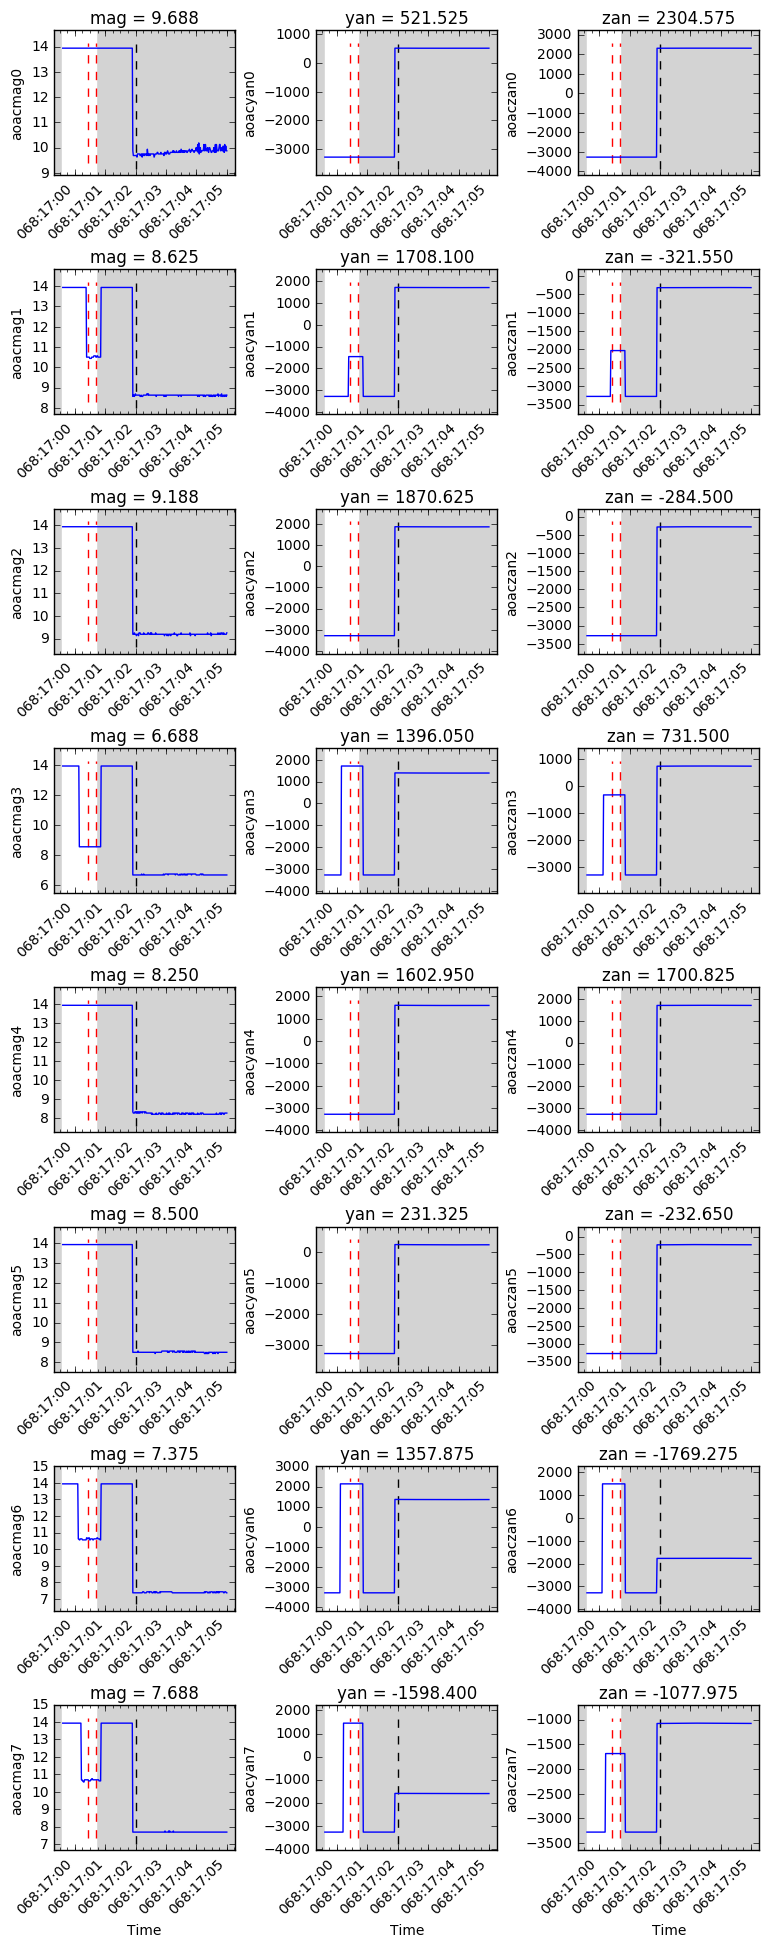

In [97]:
start_50255 = DateTime(start).plotdate
stop_50255 = DateTime(time_bsh).plotdate
obs_times = [start_50255, stop_50255]

print('White: ObsID 50255')
print('Gray: Maneuvers')

ffs = {'time': [time_ffs], 'color': ['k']}
plot_telem(msids_star, times, obs_times, ffs=ffs)

__Images acquired at <code>2017:068:17:00:30</code> <span style="color:crimson; style:bold">(red dashed lines)</span>, approximately 15 sec prior to the BSH transition:__

<img style="float: left;" src='aca-movie-2017-068-17-00-30.png' width='750'>

In [28]:
ok = t['aoacmag'] < 13
print('Telemetry acquired during the ObsID=50255 star acquisition:\n')
print(t['slot', 'aoacyan', 'aoaczan', 'aoacmag'][ok])

Telemetry acquired during the ObsID=50255 star acquisition:

slot  aoacyan   aoaczan  aoacmag
---- --------- --------- -------
   1 -1456.174 -2031.272  10.500
   3  1710.734  -325.551   8.562
   6  2131.056  1495.159  10.618
   7  1450.419 -1687.376  10.680


In [29]:
# Kadi, find_attitude
#
# ERROR
#
#    No matching solutions found.
# Try increasing distance and/or magnitude tolerance.

In [30]:
print('Stars acquired during the full field search:\n')
print(t['slot', 'aoacyan_ffs', 'aoaczan_ffs', 'aoacmag_ffs'])

Stars acquired during the full field search:

slot aoacyan_ffs aoaczan_ffs aoacmag_ffs
---- ----------- ----------- -----------
   0     521.525    2304.575       9.688
   1    1708.100    -321.550       8.625
   2    1870.625    -284.500       9.188
   3    1396.050     731.500       6.688
   4    1602.950    1700.825       8.250
   5     231.325    -232.650       8.500
   6    1357.875   -1769.275       7.375
   7   -1598.400   -1077.975       7.688


Kadi's <code>find_attitude</code> tool identified five of the stars acquired during the BSH as the commanded catalog stars (slot number/catalog slot number): 1/4, 2/3, 5/2, 6/5, 7/0.

In [48]:
# Kadi, find_attitude 
#
# Attitude solution
# Coordinates
#
# RA=41.3602996961
# Dec=-42.401664569
# Roll=244.927797277
#
# Q1=-0.804492052695
# Q2=-0.0961889595216
# Q3=0.462194927413
# Q4=0.360438719189
#
#  
# Star match summary and residuals
#
# slot   YAG       ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id   catalog_slot
# ---- -------- --------- ------- -------- ----- -------- ----- ---- ----------
#   0  521.525  2304.575   9.688       --    --       --    --   --         --    --
#   1   1708.1   -321.55   8.625  1708.17 -0.07  -321.16 -0.39 0.40  991560432    4
#   2 1870.625    -284.5   9.188  1869.83  0.79  -285.48  0.98 1.26  991559968    3
#   3  1396.05     731.5   6.688  1396.02  0.03   731.81 -0.31 0.31  991561008    below img window 8
#   4  1602.95  1700.825    8.25  1603.20 -0.25  1701.06 -0.23 0.34  991564904    above img window 8
#   5  231.325   -232.65     8.5   231.85 -0.53  -232.54 -0.11 0.54  991175320    2
#   6 1357.875 -1769.275   7.375  1357.98 -0.10 -1769.05 -0.23 0.25  991560472    5
#   7  -1598.4 -1077.975   7.688 -1598.53  0.13 -1078.27  0.29 0.32  991169936    0

q_kadi = Quat([-0.804492052695, -0.0961889595216, 0.462194927413, 0.360438719189])

# OBSID = 50255
# MP_TARGQUAT at 2017:068:16:27:17.180 (VCDU count = 7533114)
# Q1,Q2,Q3,Q4: -0.80436588  -0.09580606  0.46243239  0.36051771

q_planned = Quat([-0.80436588, -0.09580606, 0.46243239, 0.36051771])

result = get_att_offset(q_kadi, q_planned)

Offset = 148.6 arcsec
d(Roll) = 127.4 arcsec
d(Pitch) = -42.8 arcsec
d(Yaw) = 142.3 arcsec


__Use this attitude to identify the stars acquired during the acquisition phase__

In [32]:
import Ska.quatutil as quatutil
radius = (200 * u.arcsec).to('degree').value
S2D = (1 * u.arcsec).to('degree')

for idx in [1, 3, 6, 7]:
    mag = t['aoacmag'][idx]
    yag = t['aoacyan'][idx]
    zag = t['aoaczan'][idx]
    ra, dec = quatutil.yagzag2radec(yag * S2D, zag * S2D, q_kadi)
    cat = agasc.agasc.get_agasc_cone(ra=ra, dec=dec, radius=radius, date='2017:068')

    if len(cat)==0:
        print
        continue
    dists = []
    for cc in cat:
        dist = (agasc.agasc.sphere_dist(ra, dec, cc['RA'], cc['DEC']) * u.deg).to('arcsec')
        dists.append(dist.value)
    cat['DIST'] = dists
    cat['DIST'].format = '%.1f'
    cat['RA'].format = '%.2f'
    cat['DEC'].format = '%.2f'
    cat['MAG_ACA'].format = '%.3f'
    
    print('Slot {}, mag = {:.3f}, yag = {:.0f}, zag = {:.0f}'.format(idx, mag, yag, zag, ra, dec))
    print(cat['AGASC_ID', 'RA', 'DEC', 'MAG_ACA', 'DIST'])
    print()

Slot 1, mag = 10.500, yag = -1456, zag = -2031
 AGASC_ID   RA   DEC   MAG_ACA DIST
--------- ----- ------ ------- ----
991171424 40.89 -41.81  12.656 76.7

Slot 3, mag = 8.562, yag = 1711, zag = -326
 AGASC_ID   RA   DEC   MAG_ACA  DIST
--------- ----- ------ ------- -----
991559968 40.96 -42.84   9.271 163.7
991560432 40.98 -42.79   8.714   5.4
991560672 41.03 -42.79  12.316 145.8

Slot 6, mag = 10.618, yag = 2131, zag = 1495
 AGASC_ID   RA   DEC   MAG_ACA  DIST
--------- ----- ------ ------- -----
991564392 41.49 -43.16   9.972 190.5

Slot 7, mag = 10.680, yag = 1450, zag = -1687
 AGASC_ID   RA   DEC   MAG_ACA  DIST
--------- ----- ------ ------- -----
991559816 40.56 -42.62  10.269 198.9
991560472 40.54 -42.53   7.351 123.6



A true star was acquired only in slot 3 (AGASC_ID = 991560432). This star was assigned to slot 4 in the commanded catalog. Slots 3 and 4 (image windows 4 and 5) were attached to each other, see the next figure.

In [162]:
from astropy.io import ascii

# OBSID: 50255  
# RA, Dec, Roll (deg):    41.352207   -42.442511   244.957729
#
# MP_TARGQUAT at 2017:068:16:27:17.180 (VCDU count = 7533114)
#  Q1,Q2,Q3,Q4: -0.80436588  -0.09580606  0.46243239  0.36051771
#  MANVR: Angle=  95.42 deg  Duration= 1932 sec  Slew err= 71.1 arcsec
#
# MP_STARCAT at 2017:068:16:27:18.823 (VCDU count = 7533120)
# ---------------------------------------------------------------------------------------------
# IDX SLOT        ID  TYPE   SZ   P_ACQ    MAG   MAXMAG   YANG   ZANG DIM RES HALFW PASS NOTES
#---------------------------------------------------------------------------------------------
starcheck_catalog_dat = """
idx slot   id      type size   mag     maxmag yang   zang  sz   halfw
 1  0   991169936   BOT  8x8   7.662   9.172  -1741  -1120  18  110
 2  1   991170368   BOT  8x8  10.144  11.641  -1341  -2139  20  120
 3  2   991175320   BOT  8x8   8.493  10.000     89   -275  20  120
 4  3   991559968   BOT  8x8   9.271  10.781   1727   -329  12   80
 5  4   991560432   BOT  8x8   8.714  10.219   1565   -364  12   80
 6  5   991560472   BOT  8x8   7.351   8.859   1214  -1812  20  120
 7  6   991564392   BOT  8x8   9.972  11.469   2177   1420  20  120
 8  7   991563000   GUI  8x8  10.340  11.844   1226   1184   1   25
 9  7   991559816   ACQ  8x8  10.269  11.766   1481  -1635  20  120
"""
starcheck_catalog = ascii.read(starcheck_catalog_dat)

In [ ]:
#fig = plot_stars(q_planned, starcheck_catalog)
#fig = plot_stars(q_kadi, starcheck_catalog)

<div style='width: 750px'>
<div style='float: left'><img src='star_catalog_planned_att.png' width='374 px'></div>
<div style='float: left'><img src='star_catalog_true_att.png' width='374 px'></div>
</div>

In [53]:
msids = ['aoattqt{}'.format(i + 1) for i in range(4)]
telem = fetch.MSIDset(msids, start=start_av, stop=time_ffs)

q_obc_aqxn = [telem[msids[i]].vals[0] for i in range(4)]
q_obc_aqxn = Quat(q_obc_aqxn)

q_obc_ffs = [telem[msids[i]].vals[-1] for i in range(4)]
q_obc_ffs = Quat(q_obc_ffs)

dq = q_obc_ffs.dq(q_obc_aqxn)

q_aqxn_true = q_kadi * dq

print('\nOffset between true time of aqxn and planned direction:\n')
result = get_att_offset(q_aqxn_true, q_planned)


Offset between true time of aqxn and planned direction:

Offset = 150.8 arcsec
d(Roll) = 133.2 arcsec
d(Pitch) = -39.0 arcsec
d(Yaw) = 145.7 arcsec
